In [1]:
%cd /home/ubuntu/eda/flood-risk/modeling/data
from osgeo import gdal, gdal_array, osr, ogr
import numpy as np
import rasterio
from rasterio import mask
import pyproj
from affine import Affine
import pandas as pd
from shapely.geometry import Point
from geopandas import GeoDataFrame
import geopandas as gpd
from rasterio.features import shapes
import xarray
import matplotlib.pyplot as plt
import rtree
import shapely
import warnings
import time
from sklearn.cluster import AgglomerativeClustering
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import *
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from collections import defaultdict
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler
from itertools import combinations
# import hdbscan

warnings.filterwarnings('ignore')

/home/ubuntu/eda/flood-risk/modeling/data


#### High Water Mark

In [53]:
hw = pd.read_csv('./FilteredHWMs_Ida.csv')
hw.columns = hw.columns.str.lower()
hw = hw[hw.eventname == '2021 Ida']
hw = gpd.GeoDataFrame(hw[['eventname','hwmtypename', 'site_no', 'sitedescription','site_latitude', 'site_longitude', 'hwm_id','waterbody', 'site_id', 'hwm_type_id', 'hwm_quality_id','hwm_locationdescription', 'survey_date', 'elev_ft','height_above_gnd','hwm_notes', 'flag_date', 'stillwater','uncertainty','hwm_label']], 
                      geometry = gpd.points_from_xy(hw['longitude_dd'],hw['latitude_dd'])).set_crs(4326).to_crs(2263)

hw2 = pd.read_csv('./FilteredHWMs_Sandy.csv')
hw2.columns = hw2.columns.str.lower()
hw2 = hw2[hw2.eventname == '2012 Sandy']
hw2 = gpd.GeoDataFrame(hw2[['eventname','hwmtypename', 'site_no', 'sitedescription','site_latitude', 'site_longitude', 'hwm_id','waterbody', 'site_id', 'hwm_type_id', 'hwm_quality_id','hwm_locationdescription', 'survey_date', 'elev_ft','height_above_gnd','hwm_notes', 'flag_date', 'stillwater','uncertainty','hwm_label']], 
                      geometry = gpd.points_from_xy(hw2['longitude_dd'],hw2['latitude_dd'])).set_crs(4326).to_crs(2263)

In [54]:
hw = hw[['eventname','hwm_id','site_no','site_latitude','site_longitude','waterbody','survey_date','elev_ft','height_above_gnd','stillwater','geometry']].sort_values(by = ['site_no','height_above_gnd'], ascending = False).groupby('site_no').head(1)
hw2 = hw2[['eventname','hwm_id','site_no','site_latitude','site_longitude','waterbody','survey_date','elev_ft','height_above_gnd','stillwater','geometry']].sort_values(by = ['site_no','height_above_gnd'], ascending = False).groupby('site_no').head(1)

In [230]:
hw

,eventname,hwm_id,site_no,site_latitude,site_longitude,waterbody,survey_date,elev_ft,height_above_gnd,stillwater,geometry
2379,2021 Ida,41446,NYRIC31328,40.639617,-74.138260,Flash flooding,9/10/2021 4:00:00 AM,9.8,1.25,0.0,POINT (945878.446 172336.380)
2377,2021 Ida,41445,NYRIC31327,40.627809,-74.122909,Flash flooding,9/10/2021 4:00:00 AM,61.3,2.13,0.0,POINT (950132.798 168028.061)
2356,2021 Ida,40995,NYRIC31292,40.589173,-74.125210,Flash flooding,9/9/2021 4:00:00 AM,240.7,0.00,0.0,POINT (949473.965 153952.883)
2353,2021 Ida,40994,NYRIC31291,40.605487,-74.156753,Flash flooding,9/9/2021 4:00:00 AM,32.3,0.00,0.0,POINT (940723.803 159910.580)
2343,2021 Ida,40987,NYRIC31283,40.626467,-74.144491,Flash flooding,9/9/2021 4:00:00 AM,29.3,1.32,0.0,POINT (944141.244 167548.279)
...,...,...,...,...,...,...,...,...,...,...,...
2345,2021 Ida,40988,NYBRO31285,40.852566,-73.873215,Flash flooding,9/27/2021 4:00:00 AM,28.4,0.00,0.0,POINT (1019324.586 249915.662)
2321,2021 Ida,40962,NYBRO31267,40.890202,-73.895790,Flash flooding,9/18/2021 4:00:00 AM,16.2,4.97,0.0,POINT (1013062.989 263619.695)
2320,2021 Ida,41586,NYBRO31266,40.888741,-73.894397,Flash flooding,9/27/2021 4:00:00 AM,16.4,5.90,1.0,POINT (1013448.781 263087.855)
2314,2021 Ida,41593,NYBRO31263,40.833004,-73.833582,Flash flooding,9/8/2021 4:00:00 AM,17.9,2.00,1.0,POINT (1030302.433 242806.854)


In [231]:
hw2

,eventname,hwm_id,site_no,site_latitude,site_longitude,waterbody,survey_date,elev_ft,height_above_gnd,stillwater,geometry
346,2012 Sandy,6559,NYWES07670,40.948810,-73.732617,NaN,NaN,10.3,NaN,NaN,POINT (1058189.744 284571.584)
345,2012 Sandy,6558,NYWES07669,40.978565,-73.665596,NaN,NaN,9.8,NaN,NaN,POINT (1076586.014 295973.412)
344,2012 Sandy,6557,NYWES07668,40.955806,-73.692567,NaN,NaN,10.2,NaN,NaN,POINT (1069168.113 287653.854)
343,2012 Sandy,6556,NYWES07667,40.931700,-73.744700,NaN,NaN,10.1,NaN,NaN,POINT (1054793.665 278824.823)
342,2012 Sandy,6555,NYWES07666,40.908700,-73.768600,NaN,NaN,11.8,NaN,NaN,POINT (1048211.848 270426.623)
...,...,...,...,...,...,...,...,...,...,...,...
31,2012 Sandy,6218,NYBRO07396,40.804700,-73.902300,NaN,NaN,10.6,NaN,NaN,POINT (1011297.786 232466.024)
30,2012 Sandy,6217,NYBRO07395,40.823000,-73.932200,NaN,NaN,9.9,NaN,NaN,POINT (1003014.953 239125.547)
29,2012 Sandy,6216,NYBRO07394,40.842800,-73.929000,NaN,NaN,9.7,NaN,NaN,POINT (1003894.767 246340.117)
27,2012 Sandy,6214,NYALB07393,42.746840,-73.689360,NaN,NaN,10.6,NaN,NaN,POINT (1067738.917 940435.385)


In [232]:
pd.concat([hw,hw2], ignore_index = True).groupby(['eventname','waterbody'])[['site_no']].nunique()

site_no
eventname  waterbody                              
2012 Sandy Atlantic Ocean                        1
           Port Jefferson Harbor                 1
           Wading River/Long Island Sound        1
2021 Ida   Flash flooding                       82
           Harlem River                          1

In [235]:
pd.concat([hw,hw2], ignore_index = True).groupby(['eventname'])[['site_no']].nunique()

,site_no
eventname,
2012 Sandy,295
2021 Ida,83


In [240]:
pd.concat([hw,hw2], ignore_index = True).groupby(['eventname'])[['elev_ft','height_above_gnd']].agg(np.nanmean)

,elev_ft,height_above_gnd
eventname,,
2012 Sandy,9.131380,NaN
2021 Ida,40.631325,1.99962


#### _Sandy high water marks/inundation zone tied to storm surge more than flash flood risk - Ida data has stronger relationship with geographic features_

#### Sandy Inundation

In [149]:
sd = gpd.read_file('./sandy_inundation.shp').set_crs(4326).to_crs(2263)

In [150]:
sd.head()

,geometry
0,"POLYGON ((918494.320 128523.034, 918492.192 12..."
1,"POLYGON ((948808.195 138356.716, 948810.318 13..."
2,"POLYGON ((1009053.467 160146.572, 1009051.883 ..."
3,"POLYGON ((975521.372 160027.088, 975517.667 16..."
4,"POLYGON ((989512.654 160750.173, 989515.302 16..."


In [2]:
%cd /home/ubuntu/eda/data

/home/ubuntu/eda/data


#### NYC Features

In [3]:
ny = pd.read_csv('./ny_full_scaled.csv')
ny = gpd.GeoDataFrame(ny, geometry = ny['geometry'].apply(shapely.wkt.loads)).drop(columns = ['Unnamed: 0'])
ny.head()

,cb2020,borocode,boroname,ct2020,bctcb2020,geoid,shape_leng,shape_area,geometry,land_cvr_1,...,rw_length,rw_avg_elev,lake_res_ind,pond_ind,river_ind,stream_ind,wl_marsh_ind,beach_shore_ind,bay_ocean_ind,elev_mean_diff
0,1000,1,Manhattan,100,10001001000,360610001001000,2.563287,1.028343,"POLYGON ((973172.666 194632.348, 973310.630 19...",0.572610,...,-0.109035,-0.197793,0,0,1,0,0,0,1,-0.103761
1,1001,1,Manhattan,100,10001001001,360610001001001,1.328588,0.436533,"POLYGON ((972081.788 190733.467, 972184.766 19...",0.232433,...,-0.109035,-0.197793,0,0,0,0,0,1,1,0.168386
2,1000,1,Manhattan,201,10002011000,360610002011000,-0.234124,-0.099464,"POLYGON ((988376.731 199328.618, 987837.811 19...",-0.545577,...,-0.109035,-0.197793,0,0,0,0,0,0,0,0.699072
3,1001,1,Manhattan,201,10002011001,360610002011001,-0.220366,-0.088884,"POLYGON ((988392.400 199070.298, 988285.301 19...",0.030490,...,-0.109035,-0.197793,0,0,0,0,0,0,0,0.603821
4,2000,1,Manhattan,201,10002012000,360610002012000,0.034592,0.041155,"POLYGON ((988422.186 198807.188, 988449.289 19...",3.077870,...,-0.109035,-0.197793,0,0,0,0,0,0,0,0.318067


In [62]:
#geo feats and Ida high water marks
ny_hw = ny.sjoin(hw[['elev_ft','height_above_gnd','geometry']], how = 'inner', predicate = 'contains').sort_values(by = ['bctcb2020','height_above_gnd']).groupby('bctcb2020').head(1).drop(columns = ['index_right','cb2020','borocode','boroname','ct2020','geoid','geometry','ntaname']).set_index('bctcb2020')
ny_hw.head()

,shape_leng,shape_area,land_cvr_1,land_cvr_2,land_cvr_3,land_cvr_4,land_cvr_5,land_cvr_6,land_cvr_7,land_cvr_8,...,lake_res_ind,pond_ind,river_ind,stream_ind,wl_marsh_ind,beach_shore_ind,bay_ocean_ind,elev_mean_diff,elev_ft,height_above_gnd
bctcb2020,,,,,,,,,,,,,,,,,,,,,
10143001001,5.026400,3.275649,1.694165,1.827652,0.972171,2.239673,-1.641641,-0.844516,-1.388076,-0.189784,...,1,0,0,0,0,0,0,-2.709566,14.4,0.00
10287001006,-0.360039,-0.117529,-0.558164,-0.769017,-0.092682,-0.085076,0.860806,-0.001411,0.329599,-0.189784,...,0,0,0,0,0,0,0,-4.437698,20.9,1.95
10297001003,6.432535,6.325506,4.778986,0.126734,0.313258,-0.058824,-1.666643,-1.048150,-1.986473,-0.189784,...,0,0,1,0,0,0,0,1.352224,6.9,0.00
20046001008,-0.150070,-0.050504,2.859273,0.153450,-0.092682,-0.085076,-0.939228,-0.869277,-0.826934,-0.189784,...,0,0,0,0,0,0,0,-0.069743,8.6,0.34
20132005003,0.065932,-0.010251,-0.997238,-0.096887,-0.092682,-0.085076,-0.024506,0.121026,1.244447,-0.189784,...,0,0,0,0,0,0,0,-0.233031,10.0,1.70


#### RF Ida Watermarks

In [246]:
X_train, X_test, y_train, y_test = train_test_split(ny_hw.iloc[:,:-2], ny_hw.iloc[:,-2], test_size = 0.2, random_state = 42)

params = {
    'n_estimators':[150,200,250,300],
    'max_depth':[None, 8, 6, 4],
    'min_samples_split':[2,4],
    'min_samples_leaf':[1,2],
    'max_features':[None, 'sqrt', 'log2'],
    'max_leaf_nodes':[None],
    'random_state':[42],
    'warm_start':[False]
}

rf_cv = GridSearchCV(RandomForestRegressor(),
                        params,
                        scoring = 'r2',
                        cv = 5,
                        verbose = 1)
rf_cv.fit(X_train, y_train)
print(f'Best params:{rf_cv.best_estimator_}')
print(f'Train set R2: {rf_cv.best_score_}')

Fitting 5 folds for each of 192 candidates, totalling 960 fits
Best params:RandomForestRegressor(max_depth=8, max_features=None, n_estimators=150,
                      random_state=42)
Train set R2: 0.2660807205641992


In [247]:
rf = RandomForestRegressor(max_depth = 8, n_estimators = 150, random_state = 42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f'Test set R2: {r2}')

Test set R2: 0.6827440446717221


In [248]:
pd.DataFrame(rf.feature_importances_, index = rf.feature_names_in_, columns = ['importance']).sort_values('importance', ascending = False)

,importance
elev_q1,0.251912
elev_min,0.162837
elev_mean_diff,0.123744
elev_mean,0.084895
elev_q1_ct,0.069330
elev_q3,0.067026
elev_max,0.033069
elev_min_ct,0.027080
elev_var_ct,0.014269
catch_basin_count,0.013876


#### RF Sandy Watermarks

In [212]:
ny_hw2 = ny.sjoin(hw2[['elev_ft','height_above_gnd','geometry']], how = 'inner', predicate = 'contains').sort_values(by = ['bctcb2020','elev_ft'], ascending = False).groupby('bctcb2020').head(1).drop(columns = ['index_right','cb2020','borocode','boroname','ct2020','geoid','geometry','ntaname']).set_index('bctcb2020')
ny_hw2.head()

,shape_leng,shape_area,land_cvr_1,land_cvr_2,land_cvr_3,land_cvr_4,land_cvr_5,land_cvr_6,land_cvr_7,land_cvr_8,...,lake_res_ind,pond_ind,river_ind,stream_ind,wl_marsh_ind,beach_shore_ind,bay_ocean_ind,elev_mean_diff,elev_ft,height_above_gnd
bctcb2020,,,,,,,,,,,,,,,,,,,,,
50244022011,0.227909,0.022341,0.582751,0.943524,-0.092682,-0.085076,-0.293920,-0.640372,0.005596,-0.189784,...,0,0,0,0,0,0,0,-0.294264,13.2,NaN
50244021007,4.575096,3.019476,3.372256,0.662920,1.097335,0.093404,-1.372342,-0.875734,-1.730584,-0.189784,...,0,1,0,0,1,1,1,0.005098,13.2,NaN
50244011017,1.842430,0.861236,3.410761,1.123499,1.323897,-0.084944,-1.426787,-1.023343,-1.856465,-0.189784,...,0,0,1,0,0,1,0,-1.029060,13.1,NaN
50228021001,11.774504,8.679763,0.386935,6.030904,-0.092682,1.597141,-1.674613,-1.158792,-2.256871,-0.189784,...,0,1,1,0,1,0,0,-1.498513,12.3,NaN
50207021002,0.957536,0.429930,-0.228819,0.063914,0.244052,-0.037743,-0.633623,-0.827290,2.304180,-0.189784,...,0,0,1,0,0,0,0,-0.389515,11.5,NaN


In [214]:
ny_hw2

,shape_leng,shape_area,land_cvr_1,land_cvr_2,land_cvr_3,land_cvr_4,land_cvr_5,land_cvr_6,land_cvr_7,land_cvr_8,...,lake_res_ind,pond_ind,river_ind,stream_ind,wl_marsh_ind,beach_shore_ind,bay_ocean_ind,elev_mean_diff,elev_ft,height_above_gnd
bctcb2020,,,,,,,,,,,,,,,,,,,,,
50244022011,0.227909,0.022341,0.582751,0.943524,-0.092682,-0.085076,-0.293920,-0.640372,0.005596,-0.189784,...,0,0,0,0,0,0,0,-0.294264,13.2,NaN
50244021007,4.575096,3.019476,3.372256,0.662920,1.097335,0.093404,-1.372342,-0.875734,-1.730584,-0.189784,...,0,1,0,0,1,1,1,0.005098,13.2,NaN
50244011017,1.842430,0.861236,3.410761,1.123499,1.323897,-0.084944,-1.426787,-1.023343,-1.856465,-0.189784,...,0,0,1,0,0,1,0,-1.029060,13.1,NaN
50228021001,11.774504,8.679763,0.386935,6.030904,-0.092682,1.597141,-1.674613,-1.158792,-2.256871,-0.189784,...,0,1,1,0,1,0,0,-1.498513,12.3,NaN
50207021002,0.957536,0.429930,-0.228819,0.063914,0.244052,-0.037743,-0.633623,-0.827290,2.304180,-0.189784,...,0,0,1,0,0,0,0,-0.389515,11.5,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10005001013,0.517892,0.333307,-0.693447,-0.810606,1.240571,-0.085076,-0.053045,-0.946719,2.737557,-0.189784,...,0,0,0,0,0,0,0,-0.226227,11.2,NaN
10005001001,11.958850,0.294527,0.152539,-0.200902,-0.092682,0.118481,-1.413338,0.314807,1.393301,-0.189784,...,0,0,1,0,0,0,1,-0.341889,11.0,NaN
10002024000,0.916345,0.268551,0.945627,-0.128484,-0.016242,-0.015488,-1.652289,-0.908459,2.595913,-0.189784,...,0,0,1,0,0,0,0,-0.545999,11.2,NaN


In [215]:
X_train, X_test, y_train, y_test = train_test_split(ny_hw2.iloc[:,:-2], ny_hw2.iloc[:,-2], test_size = 0.2, random_state = 42)

params = {
    'n_estimators':[200,250,300],
    'max_depth':[None, 8, 5],
    'min_samples_split':[2, 4],
    'min_samples_leaf':[1, 2],
    'max_features':[None, 'sqrt', 'log2'],
    'max_leaf_nodes':[None],
    'random_state':[42],
    'warm_start':[False]
}

rf_cv = GridSearchCV(RandomForestRegressor(),
                        params,
                        scoring = 'r2',
                        cv = 5,
                        verbose = 1)
rf_cv.fit(X_train, y_train)
print(f'Best params:{rf_cv.best_estimator_}')
print(f'Train set R2: {rf_cv.best_score_}')

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best params:RandomForestRegressor(max_depth=8, max_features='log2', n_estimators=200,
                      random_state=42)
Train set R2: 0.013012004549536882


In [216]:
rf = RandomForestRegressor(max_depth = 8, n_estimators = 200, random_state = 42, max_features = 'log2')
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f'Test set R2: {r2}')

Test set R2: 0.030503100884683


In [211]:
pd.DataFrame(rf.feature_importances_, index = rf.feature_names_in_, columns = ['importance']).sort_values('importance', ascending = False)

,importance
elev_q1,0.109586
elev_mean_diff,0.065565
elev_mean,0.046097
elev_q3,0.042289
shape_leng,0.038118
elev_min,0.038016
shape_area,0.036497
land_cvr_2,0.034708
land_cvr_4,0.034674
elev_var_ct,0.033261


# Unsupervised

In [4]:
#range: [-1,1], 1 is best, close to 0 indicates overlapping clusters, negative indicates values assigned to wrong cluster
def cv_silhouette_score(estimator, X):
    estimator.fit(X)
    cluster_labels = estimator.labels_
    num_labels = len(set(cluster_labels))
    num_samples = len(X.index)
    if num_labels == 1 or num_labels == num_samples:
        return -1
    else:
        return silhouette_score(X, cluster_labels)

In [5]:
ny.columns

Index(['cb2020', 'borocode', 'boroname', 'ct2020', 'bctcb2020', 'geoid',
       'shape_leng', 'shape_area', 'geometry', 'land_cvr_1', 'land_cvr_2',
       'land_cvr_3', 'land_cvr_4', 'land_cvr_5', 'land_cvr_6', 'land_cvr_7',
       'land_cvr_8', 'ntaname', 'land_cvr_1_ct', 'land_cvr_2_ct',
       'land_cvr_3_ct', 'land_cvr_4_ct', 'land_cvr_5_ct', 'land_cvr_6_ct',
       'land_cvr_7_ct', 'land_cvr_8_ct', 'elev_mean', 'elev_min', 'elev_max',
       'elev_q1', 'elev_q3', 'elev_var', 'elev_mean_ct', 'elev_min_ct',
       'elev_max_ct', 'elev_q1_ct', 'elev_q3_ct', 'elev_var_ct',
       'catch_basin_count', 'catch_basin_density', 'sub_entr_count',
       'rw_length', 'rw_avg_elev', 'lake_res_ind', 'pond_ind', 'river_ind',
       'stream_ind', 'wl_marsh_ind', 'beach_shore_ind', 'bay_ocean_ind',
       'elev_mean_diff'],
      dtype='object')

In [255]:
%%time
feat_cols = ['land_cvr_1', 'land_cvr_2','land_cvr_3','land_cvr_6','land_cvr_7',
             'land_cvr_1_ct', 'land_cvr_2_ct','land_cvr_3_ct','land_cvr_6_ct',
             'land_cvr_7_ct','elev_mean', 'elev_min','elev_max','elev_q1','elev_q3',
             'elev_var','elev_mean_ct', 'elev_min_ct','elev_q1_ct','elev_var_ct',
             'catch_basin_density','wl_marsh_ind','elev_mean_diff']
params = {
    'n_clusters':[4,5,6,7,8],
    'affinity':['euclidean'],
    'linkage':['ward']
}

ac_cv = GridSearchCV(estimator = AgglomerativeClustering(),
                     param_grid = params,
                     scoring = cv_silhouette_score,
                     cv = [(slice(None),slice(None))],
                     verbose = 3)
ac_cv.fit(ny[feat_cols])
print(f'Best params:{ac_cv.best_estimator_}')
print(f'Best silhouette score: {ac_cv.best_score_}')

Fitting 1 folds for each of 5 candidates, totalling 5 fits
[CV 1/1] END affinity=euclidean, linkage=ward, n_clusters=4;, score=0.111 total time= 2.9min
[CV 1/1] END affinity=euclidean, linkage=ward, n_clusters=5;, score=0.099 total time= 2.9min
[CV 1/1] END affinity=euclidean, linkage=ward, n_clusters=6;, score=0.104 total time= 2.9min
[CV 1/1] END affinity=euclidean, linkage=ward, n_clusters=7;, score=0.108 total time= 2.9min
[CV 1/1] END affinity=euclidean, linkage=ward, n_clusters=8;, score=0.111 total time= 2.9min
Best params:AgglomerativeClustering(n_clusters=8)
Best silhouette score: 0.1114820227764991
CPU times: user 15min 50s, sys: 10min 37s, total: 26min 28s
Wall time: 15min 33s


##### Reduced Feat Set

In [256]:
%%time
feat_cols = ['land_cvr_2','land_cvr_6','land_cvr_7','land_cvr_2_ct','land_cvr_6_ct',
             'land_cvr_7_ct','elev_mean', 'elev_min','elev_max','elev_q1','elev_q3',
             'elev_var','elev_mean_ct', 'elev_min_ct','elev_q1_ct','elev_var_ct',
             'catch_basin_density','elev_mean_diff']
params = {
    'n_clusters':[4,5,6,7,8],
    'affinity':['euclidean'],
    'linkage':['ward']
}

ac_cv = GridSearchCV(estimator = AgglomerativeClustering(),
                     param_grid = params,
                     scoring = cv_silhouette_score,
                     cv = [(slice(None),slice(None))],
                     verbose = 3)
ac_cv.fit(ny[feat_cols])
print(f'Best params:{ac_cv.best_estimator_}')
print(f'Best silhouette score: {ac_cv.best_score_}')

Fitting 1 folds for each of 5 candidates, totalling 5 fits
[CV 1/1] END affinity=euclidean, linkage=ward, n_clusters=4;, score=0.239 total time= 2.7min
[CV 1/1] END affinity=euclidean, linkage=ward, n_clusters=5;, score=0.227 total time= 2.7min
[CV 1/1] END affinity=euclidean, linkage=ward, n_clusters=6;, score=0.115 total time= 2.7min
[CV 1/1] END affinity=euclidean, linkage=ward, n_clusters=7;, score=0.109 total time= 2.7min
[CV 1/1] END affinity=euclidean, linkage=ward, n_clusters=8;, score=0.117 total time= 2.7min
Best params:AgglomerativeClustering(n_clusters=4)
Best silhouette score: 0.23891891509869256
CPU times: user 15min 4s, sys: 10min 47s, total: 25min 51s
Wall time: 14min 49s


# Clustering Iterations

In [6]:
class PFA(object):
    def __init__(self, n_features, q=None):
        self.q = q
        self.n_features = n_features
    
    def fit(self, X):
        if not self.q:
            self.q = X.shape[1]
    
        sc = StandardScaler()
        X = sc.fit_transform(X)
    
        pca = PCA(n_components=self.q).fit(X) # calculation Covmatrix is embeded in PCA
        A_q = pca.components_.T
    
        kmeans = KMeans(n_clusters=self.n_features).fit(A_q)
        clusters = kmeans.predict(A_q)
        cluster_centers = kmeans.cluster_centers_
    
        dists = defaultdict(list)
        for i, c in enumerate(clusters):
            dist = euclidean_distances([A_q[i, :]], [cluster_centers[c, :]])[0][0]
            dists[c].append((i, dist))
    
        self.indices_ = [sorted(f, key=lambda x: x[1])[0][0] for f in dists.values()]
        self.features_ = X[:, self.indices_]

In [7]:
ny.columns

Index(['cb2020', 'borocode', 'boroname', 'ct2020', 'bctcb2020', 'geoid',
       'shape_leng', 'shape_area', 'geometry', 'land_cvr_1', 'land_cvr_2',
       'land_cvr_3', 'land_cvr_4', 'land_cvr_5', 'land_cvr_6', 'land_cvr_7',
       'land_cvr_8', 'ntaname', 'land_cvr_1_ct', 'land_cvr_2_ct',
       'land_cvr_3_ct', 'land_cvr_4_ct', 'land_cvr_5_ct', 'land_cvr_6_ct',
       'land_cvr_7_ct', 'land_cvr_8_ct', 'elev_mean', 'elev_min', 'elev_max',
       'elev_q1', 'elev_q3', 'elev_var', 'elev_mean_ct', 'elev_min_ct',
       'elev_max_ct', 'elev_q1_ct', 'elev_q3_ct', 'elev_var_ct',
       'catch_basin_count', 'catch_basin_density', 'sub_entr_count',
       'rw_length', 'rw_avg_elev', 'lake_res_ind', 'pond_ind', 'river_ind',
       'stream_ind', 'wl_marsh_ind', 'beach_shore_ind', 'bay_ocean_ind',
       'elev_mean_diff'],
      dtype='object')

In [8]:
feat_data = ny.set_index('bctcb2020').drop(columns = ['cb2020','borocode','boroname','ct2020','geoid','shape_leng','shape_area','geometry','ntaname'])

In [9]:
%%time
pfa = PFA(n_features=3)
pfa.fit(feat_data)
# To get the transformed matrix
x = pfa.features_
print(x)
# To get the column indices of the kept features
column_indices = pfa.indices_

[[ 0.57261029 -0.10376098 -1.00199711]
 [ 0.23243312  0.16838579 -1.00199711]
 [-0.54557671  0.699072   -0.92173836]
 ...
 [ 0.77492482  0.12756378 -1.00199711]
 [-1.12284076 -0.00850961 -1.16251463]
 [ 0.92840045 -0.00850961 -1.16251463]]
CPU times: user 1.28 s, sys: 1.26 s, total: 2.54 s
Wall time: 285 ms


In [10]:
column_indices

[0, 40, 25]

In [11]:
feat_data.iloc[:,column_indices].columns

Index(['land_cvr_1', 'elev_mean_diff', 'elev_q1_ct'], dtype='object')

In [319]:
feat_data.columns[[12,1,14]].to_list()

['land_cvr_5_ct', 'land_cvr_2', 'land_cvr_7_ct']

In [285]:
feat_data.iloc[:,[12,1,14]]

,land_cvr_5_ct,land_cvr_2,land_cvr_7_ct
bctcb2020,,,
10001001000,-0.320335,1.381106,0.057584
10001001001,-0.320335,1.488185,0.057584
10002011000,0.129626,-0.321754,0.240761
10002011001,0.129626,-0.778791,0.240761
10002012000,0.129626,-0.525972,0.240761
...,...,...,...
50323001025,-2.067946,3.923461,0.349343
50323001014,-2.067946,-0.459392,0.349343
50323001015,-2.067946,2.409229,0.349343


In [9]:
def agg_clust(df, min_feats, max_feats, min_clust, max_clust):
    
    result_dict = {
    'features':[],
    'params':[],
    'scores':[]
    }
    
    print('-'*20)
    
    for num_feat in range(min_feats,max_feats+1):
        pfa = PFA(n_features=num_feat)
        pfa.fit(df)
        print(f'Number of features: {num_feat}')
        print(f'Features:{df.columns[pfa.indices_].to_list()}')
        
        result_dict['features'].append(df.columns[pfa.indices_].to_list())
        
        ac_cv = GridSearchCV(estimator = AgglomerativeClustering(),
                     param_grid = {'n_clusters':[i for i in range(min_clust,max_clust+1)]},
                     scoring = cv_silhouette_score,
                     cv = [(slice(None),slice(None))],
                     verbose = 3)
        
        ac_cv.fit(df.iloc[:,pfa.indices_])
        print(f'Best params:{ac_cv.best_estimator_}')
        result_dict['params'].append(ac_cv.best_estimator_)
        print(f'Best silhouette score: {ac_cv.best_score_}')
        result_dict['scores'].append(ac_cv.best_score_)
        print('-'*20)
    print('-'*20)
    results = pd.DataFrame(result_dict).sort_values(by = 'scores', ascending = False)
    return results

# def agg_clust_fixed_num(df, feats, num_clust):
##WIP    
#     result_dict = {
#     'features':[],
#     'params':[],
#     'scores':[]
#     }
    
#     print('-'*20)
    
#     for combo in combinations(df.columns.to_list(),feats):
# #         pfa = PFA(n_features=feats)
# #         pfa.fit(df)
# #         print(f'Number of features: {num_feat}')
# #         print(f'Features:{df.columns[pfa.indices_].to_list()}')
        
#         result_dict['features'].append(combo)
        
#         ac_cv = GridSearchCV(estimator = AgglomerativeClustering(),
#                      param_grid = {'n_clusters':[num_clust]},
#                      scoring = cv_silhouette_score,
#                      cv = [(slice(None),slice(None))],
#                      verbose = 3)
        
#         ac_cv.fit(df[combo])
#         print(f'Best params:{ac_cv.best_estimator_}')
#         result_dict['params'].append(ac_cv.best_estimator_)
#         print(f'Best silhouette score: {ac_cv.best_score_}')
#         result_dict['scores'].append(ac_cv.best_score_)
#         print('-'*20)
#     print('-'*20)
#     results = pd.DataFrame(result_dict).sort_values(by = 'scores', ascending = False)
#     return results

In [309]:
agg_clust(feat_data, 5, 8, 3, 5)

Features:Index(['elev_mean_diff', 'lake_res_ind', 'land_cvr_3', 'land_cvr_5',
       'wl_marsh_ind'],
      dtype='object')
Fitting 1 folds for each of 3 candidates, totalling 3 fits
[CV 1/1] END ......................n_clusters=3;, score=0.271 total time= 2.6min
[CV 1/1] END ......................n_clusters=4;, score=0.312 total time= 2.6min
[CV 1/1] END ......................n_clusters=5;, score=0.336 total time= 2.6min
Best params:AgglomerativeClustering(n_clusters=5)
Best silhouette score: 0.3363721267361537
Features:Index(['elev_mean_diff', 'land_cvr_5_ct', 'land_cvr_8', 'elev_mean_ct',
       'elev_q1_ct', 'elev_q3_ct'],
      dtype='object')
Fitting 1 folds for each of 3 candidates, totalling 3 fits
[CV 1/1] END ......................n_clusters=3;, score=0.455 total time= 2.3min
[CV 1/1] END ......................n_clusters=4;, score=0.210 total time= 2.3min
[CV 1/1] END ......................n_clusters=5;, score=0.211 total time= 2.3min
Best params:AgglomerativeClustering(n_clu

In [324]:
%%time
agg_clust(feat_data, 5, 5, 3, 3)

--------------------
Number of features: 5
Features:['elev_mean_diff', 'lake_res_ind', 'land_cvr_4', 'land_cvr_6_ct', 'sub_entr_count']
Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV 1/1] END ......................n_clusters=3;, score=0.673 total time= 2.6min
Best params:AgglomerativeClustering(n_clusters=3)
Best silhouette score: 0.6734714358499745 

--------------------
--------------------
CPU times: user 3min 47s, sys: 2min 12s, total: 5min 59s
Wall time: 3min 46s


,features,params,scores
0,"[elev_mean_diff, lake_res_ind, land_cvr_4, lan...",AgglomerativeClustering(n_clusters=3),0.673471


In [ ]:
%%time
res = agg_clust(feat_data, 5, 15, 3, 10)
res

--------------------
Number of features: 5
Features:['land_cvr_5_ct', 'land_cvr_2', 'land_cvr_3', 'land_cvr_7_ct', 'elev_min']
Fitting 1 folds for each of 8 candidates, totalling 8 fits
[CV 1/1] END ......................n_clusters=3;, score=0.306 total time= 2.4min
[CV 1/1] END ......................n_clusters=4;, score=0.173 total time= 2.4min
[CV 1/1] END ......................n_clusters=5;, score=0.196 total time= 2.4min
[CV 1/1] END ......................n_clusters=6;, score=0.198 total time= 2.4min
[CV 1/1] END ......................n_clusters=7;, score=0.199 total time= 2.4min
[CV 1/1] END ......................n_clusters=8;, score=0.174 total time= 2.3min
[CV 1/1] END ......................n_clusters=9;, score=0.152 total time= 2.3min
[CV 1/1] END .....................n_clusters=10;, score=0.156 total time= 2.3min
Best params:AgglomerativeClustering(n_clusters=3)
Best silhouette score: 0.3062473999670473
--------------------
Number of features: 6
Features:['land_cvr_5_ct', 'cat

In [8]:
feat_data

,land_cvr_1,land_cvr_2,land_cvr_3,land_cvr_4,land_cvr_5,land_cvr_6,land_cvr_7,land_cvr_8,land_cvr_1_ct,land_cvr_2_ct,...,rw_length,rw_avg_elev,lake_res_ind,pond_ind,river_ind,stream_ind,wl_marsh_ind,beach_shore_ind,bay_ocean_ind,elev_mean_diff
bctcb2020,,,,,,,,,,,,,,,,,,,,,
10001001000,0.572610,1.381106,-0.033645,-0.006112,0.107531,-1.175120,-0.118769,-0.189784,0.455223,1.422246,...,-0.109035,-0.197793,0,0,1,0,0,0,1,-0.103761
10001001001,0.232433,1.488185,2.005094,0.100639,-0.647376,-1.184277,0.521597,-0.189784,0.455223,1.422246,...,-0.109035,-0.197793,0,0,0,0,0,1,1,0.168386
10002011000,-0.545577,-0.321754,-0.092682,-0.085076,0.852189,-0.068779,0.050501,-0.189784,0.402960,-0.865885,...,-0.109035,-0.197793,0,0,0,0,0,0,0,0.699072
10002011001,0.030490,-0.778791,-0.092682,-0.085076,0.935942,-0.080081,-0.334520,-0.189784,0.402960,-0.865885,...,-0.109035,-0.197793,0,0,0,0,0,0,0,0.603821
10002012000,3.077870,-0.525972,-0.042710,-0.085076,-1.012724,-0.340053,-1.231099,-0.189784,0.402960,-0.865885,...,-0.109035,-0.197793,0,0,0,0,0,0,0,0.318067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50323001025,1.239850,3.923461,-0.092682,0.434529,-1.680086,-0.372929,-2.127389,-0.189784,0.500362,2.027130,...,-0.109035,-0.197793,0,0,0,1,1,0,0,0.025509
50323001014,-0.535294,-0.459392,-0.092682,-0.085076,-0.227199,-0.510082,1.864635,0.764090,0.500362,2.027130,...,-0.109035,-0.197793,0,0,0,0,0,0,0,1.495101
50323001015,0.774925,2.409229,-0.092682,2.430465,-1.250892,-0.839560,-1.141956,-0.017711,0.500362,2.027130,...,0.591361,0.827865,0,1,0,1,1,0,0,0.127564


In [16]:
agg_clust(feat_data[['elev_mean_diff','elev_q1','elev_q3','land_cvr_2_ct','catch_basin_density','wl_marsh_ind','elev_var']],
          7,
          7,
          3,
          8)

--------------------
Number of features: 7
Features:['elev_mean_diff', 'elev_q1', 'elev_q3', 'land_cvr_2_ct', 'catch_basin_density', 'wl_marsh_ind', 'elev_var']
Fitting 1 folds for each of 6 candidates, totalling 6 fits
[CV 1/1] END ......................n_clusters=3;, score=0.400 total time= 2.5min
[CV 1/1] END ......................n_clusters=4;, score=0.165 total time= 2.5min
[CV 1/1] END ......................n_clusters=5;, score=0.165 total time= 2.4min
[CV 1/1] END ......................n_clusters=6;, score=0.173 total time= 2.4min
[CV 1/1] END ......................n_clusters=7;, score=0.174 total time= 2.4min
[CV 1/1] END ......................n_clusters=8;, score=0.181 total time= 2.4min
Best params:AgglomerativeClustering(n_clusters=3)
Best silhouette score: 0.40021828294981665
--------------------
--------------------


,features,params,scores
0,"[elev_mean_diff, elev_q1, elev_q3, land_cvr_2_...",AgglomerativeClustering(n_clusters=3),0.400218


In [20]:
agg_clust(feat_data[['elev_mean_diff','land_cvr_1','wl_marsh_ind','land_cvr_3','river_ind','land_cvr_5_ct','land_cvr_3_ct','elev_var','elev_var_ct','elev_mean','catch_basin_count']],
          11,
          11,
          3,
          6)

--------------------
Number of features: 11
Features:['elev_mean_diff', 'land_cvr_1', 'wl_marsh_ind', 'land_cvr_3', 'river_ind', 'land_cvr_5_ct', 'land_cvr_3_ct', 'elev_var', 'elev_var_ct', 'elev_mean', 'catch_basin_count']
Fitting 1 folds for each of 4 candidates, totalling 4 fits
[CV 1/1] END ......................n_clusters=3;, score=0.709 total time= 2.7min
[CV 1/1] END ......................n_clusters=4;, score=0.464 total time= 2.7min
[CV 1/1] END ......................n_clusters=5;, score=0.101 total time= 2.7min
[CV 1/1] END ......................n_clusters=6;, score=0.113 total time= 2.7min
Best params:AgglomerativeClustering(n_clusters=3)
Best silhouette score: 0.7093525873584837
--------------------
--------------------


,features,params,scores
0,"[elev_mean_diff, land_cvr_1, wl_marsh_ind, lan...",AgglomerativeClustering(n_clusters=3),0.709353


In [21]:
agg_clust(feat_data[['elev_mean_diff','wl_marsh_ind','land_cvr_3','river_ind','land_cvr_5_ct','land_cvr_3_ct','elev_var','elev_var_ct','elev_mean','catch_basin_count']],
          10,
          10,
          3,
          6)

--------------------
Number of features: 10
Features:['elev_mean_diff', 'wl_marsh_ind', 'land_cvr_3', 'river_ind', 'land_cvr_5_ct', 'land_cvr_3_ct', 'elev_var', 'elev_var_ct', 'elev_mean', 'catch_basin_count']
Fitting 1 folds for each of 4 candidates, totalling 4 fits
[CV 1/1] END ......................n_clusters=3;, score=0.766 total time= 2.7min
[CV 1/1] END ......................n_clusters=4;, score=0.315 total time= 2.7min
[CV 1/1] END ......................n_clusters=5;, score=0.334 total time= 2.7min
[CV 1/1] END ......................n_clusters=6;, score=0.168 total time= 2.6min
Best params:AgglomerativeClustering(n_clusters=3)
Best silhouette score: 0.766115071776581
--------------------
--------------------


,features,params,scores
0,"[elev_mean_diff, wl_marsh_ind, land_cvr_3, riv...",AgglomerativeClustering(n_clusters=3),0.766115


In [23]:
agg_clust(feat_data[['elev_mean_diff','wl_marsh_ind','river_ind','land_cvr_5_ct','land_cvr_2','elev_var','elev_var_ct','elev_mean','catch_basin_count']],
          9,
          9,
          3,
          6)

--------------------
Number of features: 9
Features:['elev_mean_diff', 'wl_marsh_ind', 'river_ind', 'land_cvr_5_ct', 'land_cvr_2', 'elev_var', 'elev_var_ct', 'elev_mean', 'catch_basin_count']
Fitting 1 folds for each of 4 candidates, totalling 4 fits
[CV 1/1] END ......................n_clusters=3;, score=0.170 total time= 2.5min
[CV 1/1] END ......................n_clusters=4;, score=0.179 total time= 2.5min
[CV 1/1] END ......................n_clusters=5;, score=0.165 total time= 2.5min
[CV 1/1] END ......................n_clusters=6;, score=0.166 total time= 2.5min
Best params:AgglomerativeClustering(n_clusters=4)
Best silhouette score: 0.1787940574531499
--------------------
--------------------


,features,params,scores
0,"[elev_mean_diff, wl_marsh_ind, river_ind, land...",AgglomerativeClustering(n_clusters=4),0.178794


In [10]:
feats = ['elev_mean_diff','wl_marsh_ind','land_cvr_3','river_ind','land_cvr_5_ct','land_cvr_3_ct','elev_var','elev_var_ct','elev_mean','catch_basin_count']

In [11]:
feats2 = ['elev_mean_diff', 'land_cvr_1', 'wl_marsh_ind', 'land_cvr_3', 'river_ind', 'land_cvr_5_ct', 'land_cvr_3_ct', 'elev_var', 'elev_var_ct', 'elev_mean', 'catch_basin_count']

### AC Models

In [12]:
ac = AgglomerativeClustering(n_clusters = 3, compute_distances = True)
ac.fit(feat_data[feats])

AgglomerativeClustering(compute_distances=True, n_clusters=3)

In [13]:
ac2 = AgglomerativeClustering(n_clusters = 4, compute_distances = True)
ac2.fit(feat_data[feats2])

AgglomerativeClustering(compute_distances=True, n_clusters=4)

In [14]:
feat_data['cluster_4'] = ac2.labels_

In [15]:
feat_data['cluster_3'] = ac.labels_

In [16]:
ny = ny.set_index('bctcb2020')

In [17]:
ny.columns

Index(['cb2020', 'borocode', 'boroname', 'ct2020', 'geoid', 'shape_leng',
       'shape_area', 'geometry', 'land_cvr_1', 'land_cvr_2', 'land_cvr_3',
       'land_cvr_4', 'land_cvr_5', 'land_cvr_6', 'land_cvr_7', 'land_cvr_8',
       'ntaname', 'land_cvr_1_ct', 'land_cvr_2_ct', 'land_cvr_3_ct',
       'land_cvr_4_ct', 'land_cvr_5_ct', 'land_cvr_6_ct', 'land_cvr_7_ct',
       'land_cvr_8_ct', 'elev_mean', 'elev_min', 'elev_max', 'elev_q1',
       'elev_q3', 'elev_var', 'elev_mean_ct', 'elev_min_ct', 'elev_max_ct',
       'elev_q1_ct', 'elev_q3_ct', 'elev_var_ct', 'catch_basin_count',
       'catch_basin_density', 'sub_entr_count', 'rw_length', 'rw_avg_elev',
       'lake_res_ind', 'pond_ind', 'river_ind', 'stream_ind', 'wl_marsh_ind',
       'beach_shore_ind', 'bay_ocean_ind', 'elev_mean_diff'],
      dtype='object')

In [18]:
df = ny[['cb2020','borocode','boroname','ct2020','geoid','shape_leng','shape_area','geometry','ntaname']].join(feat_data[['cluster_3','cluster_4']])
df.head()

,cb2020,borocode,boroname,ct2020,geoid,shape_leng,shape_area,geometry,ntaname,cluster_3,cluster_4
bctcb2020,,,,,,,,,,,
10001001000,1000,1,Manhattan,100,360610001001000,2.563287,1.028343,"POLYGON ((973172.666 194632.348, 973310.630 19...",The Battery-Governors Island-Ellis Island-Libe...,0,0
10001001001,1001,1,Manhattan,100,360610001001001,1.328588,0.436533,"POLYGON ((972081.788 190733.467, 972184.766 19...",The Battery-Governors Island-Ellis Island-Libe...,0,0
10002011000,1000,1,Manhattan,201,360610002011000,-0.234124,-0.099464,"POLYGON ((988376.731 199328.618, 987837.811 19...",Chinatown-Two Bridges,0,0
10002011001,1001,1,Manhattan,201,360610002011001,-0.220366,-0.088884,"POLYGON ((988392.400 199070.298, 988285.301 19...",Chinatown-Two Bridges,0,0
10002012000,2000,1,Manhattan,201,360610002012000,0.034592,0.041155,"POLYGON ((988422.186 198807.188, 988449.289 19...",Chinatown-Two Bridges,0,0


<AxesSubplot: >

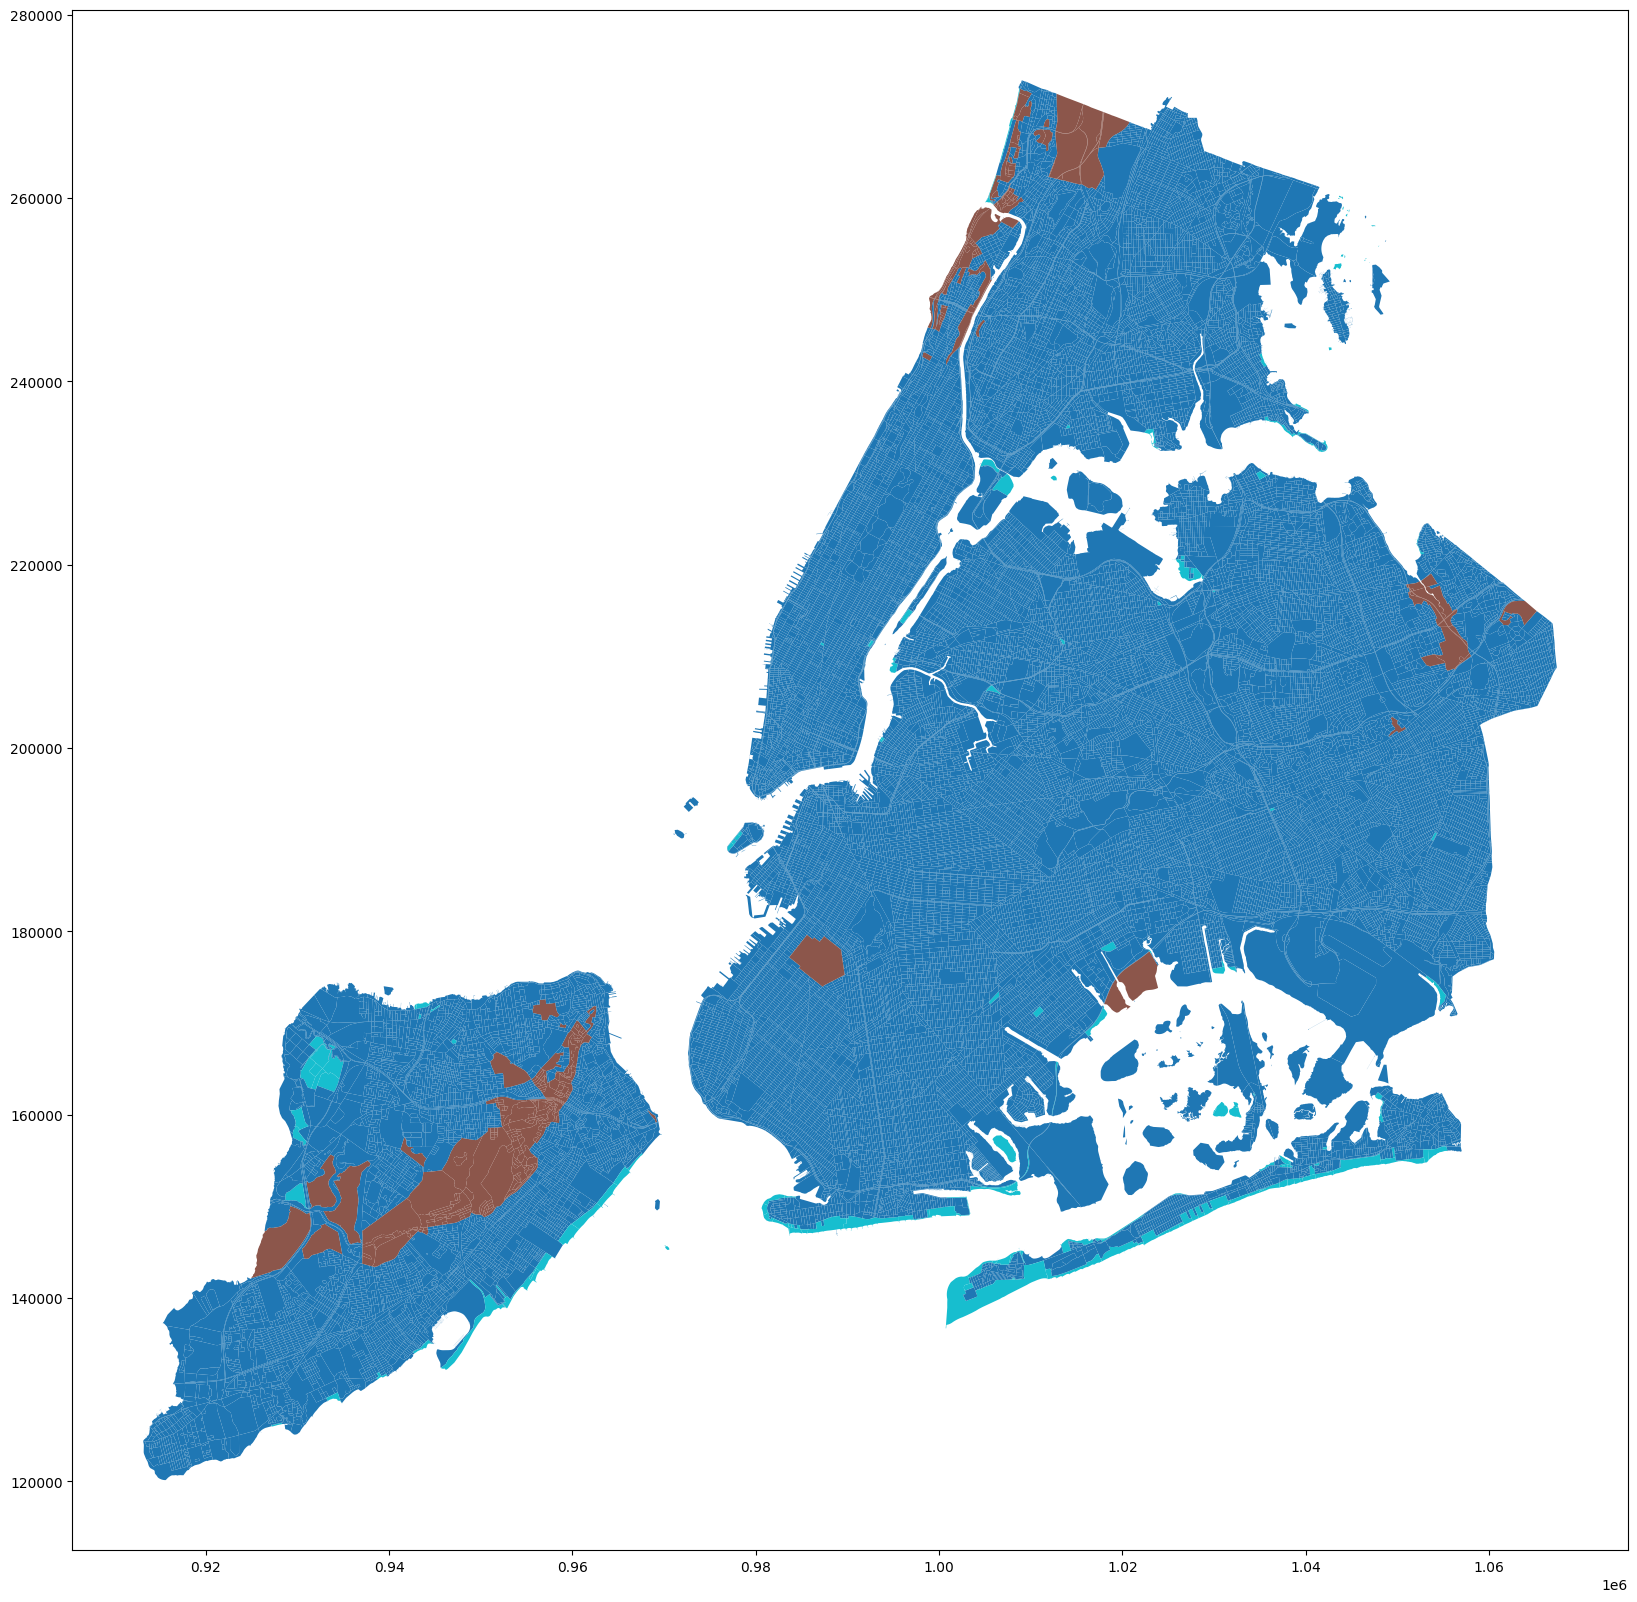

In [19]:
df.plot(column = 'cluster_3',
        categorical=True,
        figsize = (25, 20))

<AxesSubplot: >

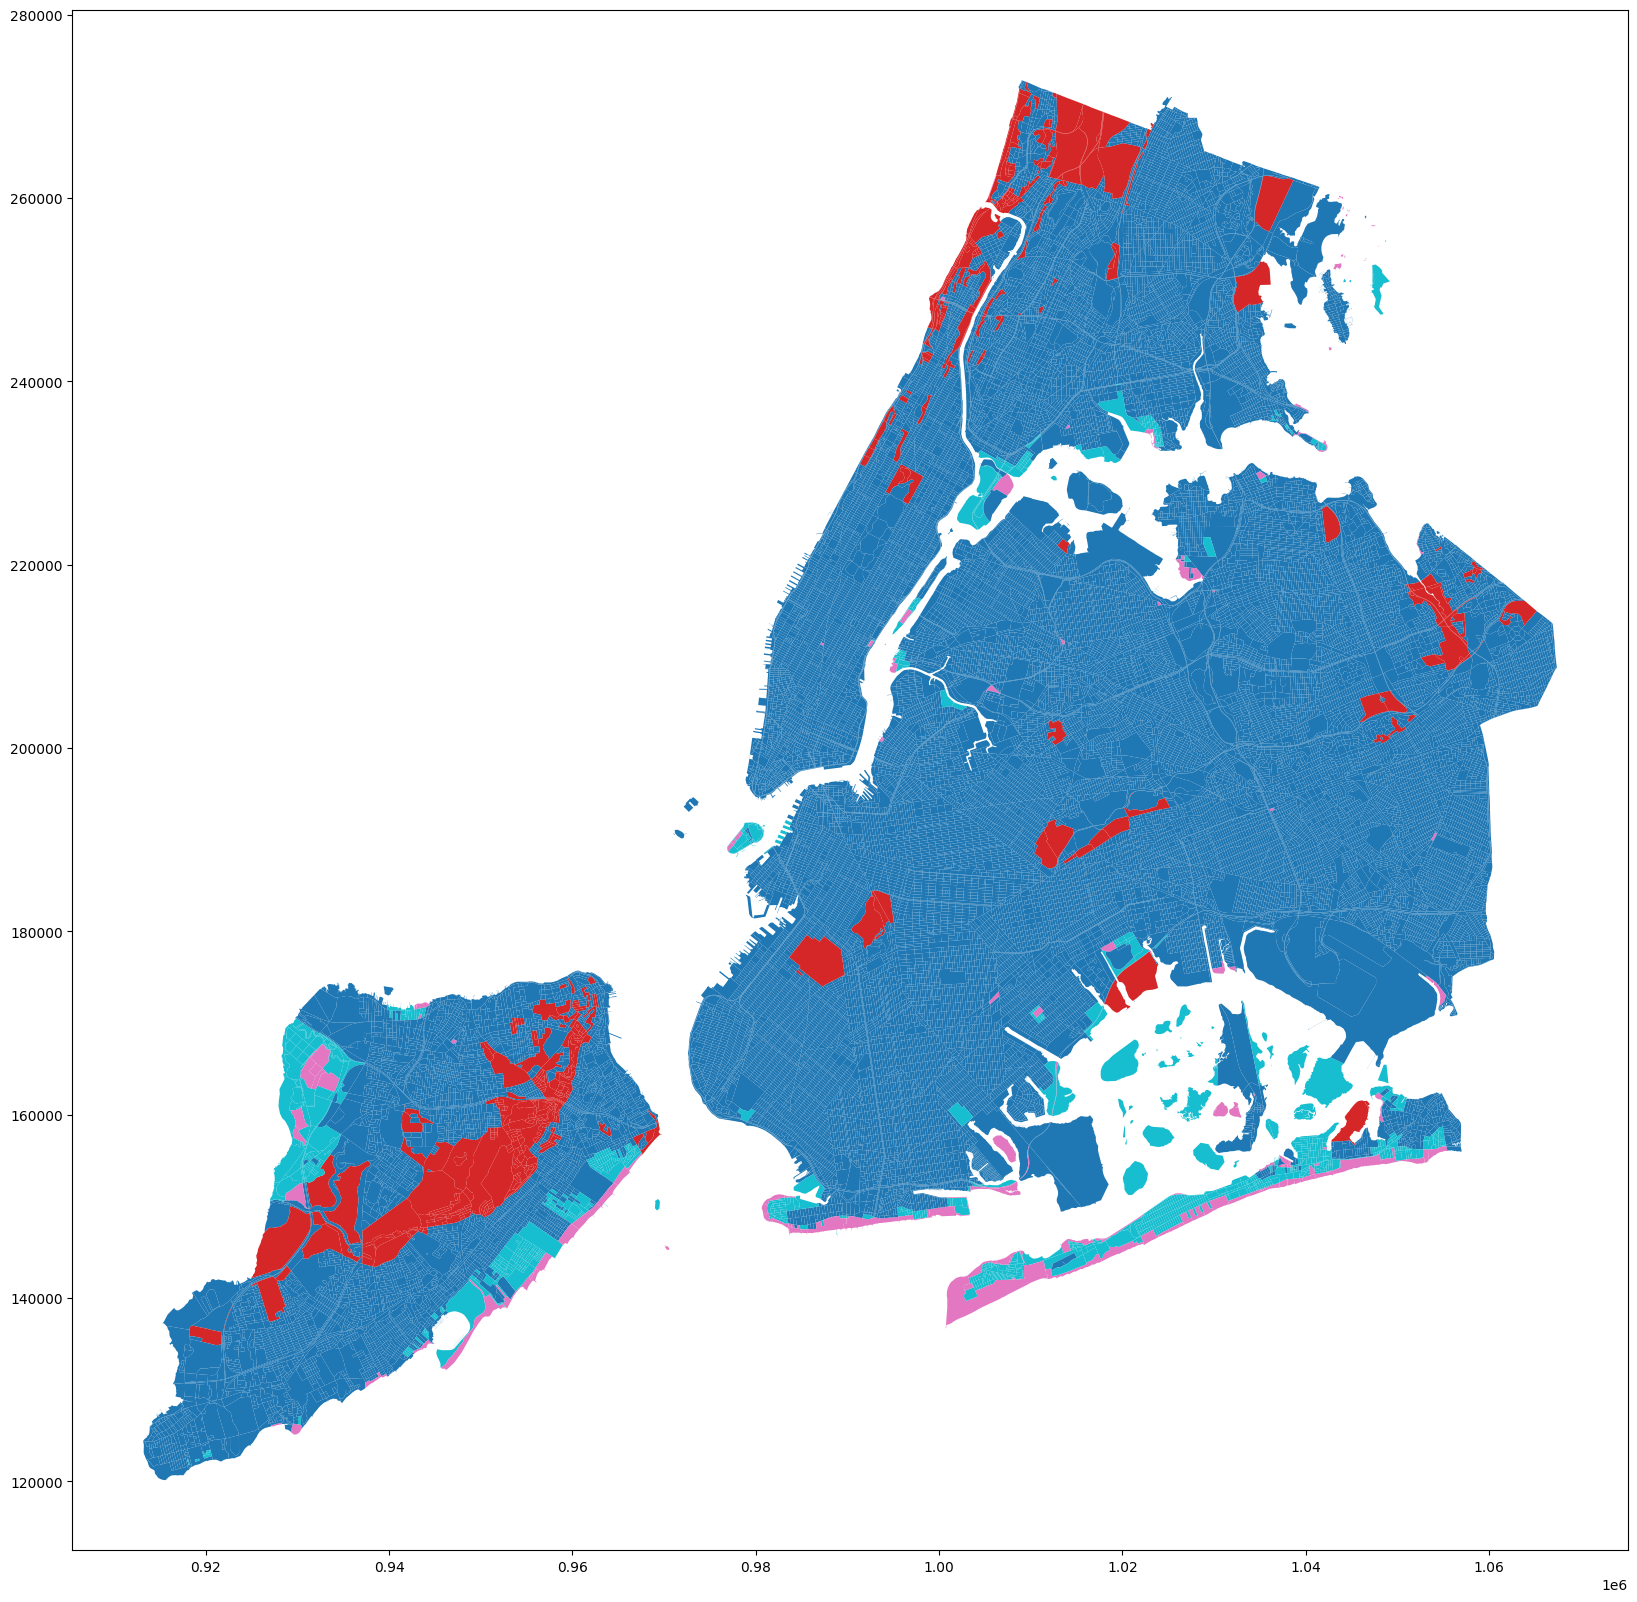

In [20]:
df.plot(column = 'cluster_4',
        categorical=True,
        figsize = (25, 20))

#### RF model using feats in cluster to validate

In [87]:
X_train, X_test, y_train, y_test = train_test_split(ny_hw[feats2], ny_hw.iloc[:,-2], test_size = 0.20, random_state = 0)

In [88]:
%%time
params = {
    'n_estimators':[200,300,400],
    'max_depth':[None, 8, 6, 4],
    'min_samples_split':[2,4],
    'min_samples_leaf':[1,2],
    'max_features':[None, 'sqrt', 'log2'],
    'max_leaf_nodes':[None],
    'random_state':[42],
    'warm_start':[False]
}

rf_cv = GridSearchCV(RandomForestRegressor(),
                        params,
                        scoring = 'r2',
                        cv = 5,
                        verbose = 1)
rf_cv.fit(X_train, y_train)
print(f'Best params:{rf_cv.best_estimator_}')
print(f'Train set R2: {rf_cv.best_score_}')

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best params:RandomForestRegressor(max_depth=4, max_features='sqrt', n_estimators=200,
                      random_state=42)
Train set R2: 0.4671233077339688
CPU times: user 5min 17s, sys: 1.66 s, total: 5min 18s
Wall time: 5min 18s


In [86]:
rf = RandomForestRegressor(n_estimators = 200, random_state = 42, max_features = 'sqrt')
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f'Test set R2: {r2}')

Test set R2: 0.4640774673738408


In [21]:
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


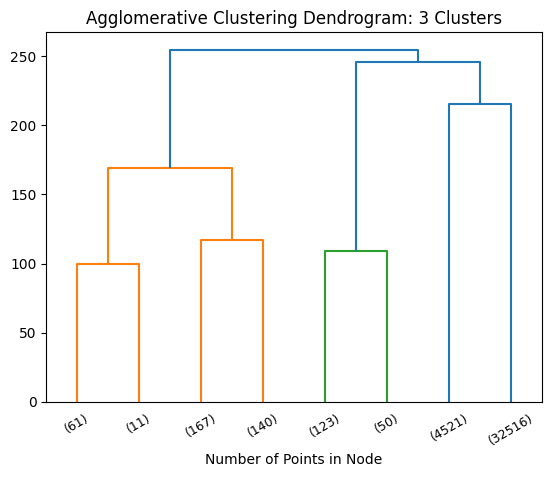

In [39]:
plt.title('Agglomerative Clustering Dendrogram: 3 Clusters')
plot_dendrogram(ac, truncate_mode = 'level', p = 2, leaf_rotation = 30, leaf_font_size = 9)
plt.xlabel('Number of Points in Node')
plt.show()

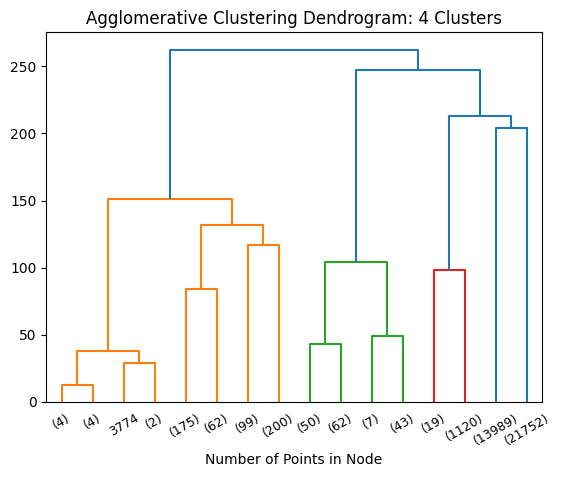

In [37]:
plt.title('Agglomerative Clustering Dendrogram: 4 Clusters')
plot_dendrogram(ac2, truncate_mode = 'level', p = 3, leaf_rotation = 30, leaf_font_size = 9)
plt.xlabel('Number of Points in Node')
plt.show()